## Deep Learning with Python ３章勉強ノート（その１）
ManningのMEAP（出版前の本のできた部分から読めるサービス）でTensorFlowとTheanoの両方に対応したラッパーツールkerasの作者Francois Chollet氏の「Deep Learning with Python」が発売されました。

３章では、通常は機械学習の方法を使って行われる、以下の処理をニューラルネットワークを使って実現する方法を紹介しています。
- 二項分類（binary classification）
- マルチクラス分類(multi-class classification)
- 線形回帰(regression)

ここでは、最初の二項分類の例題をSageのjupyterノートブックで試しながら、Deep Learningへの理解を深めたいと思います。

### kerasのインストール方法
本文ではkerasのインストール方法が詳しく紹介されていますが、GPUを使わないkerasをdockerのイメージにインストール済みです。
takepwave/sagemathのdockerイメージを使えば、すぐに二項分類を試すことができます。

### 前準備
jupyterノートブックで使用するnumpy、pandasとmatplotlibをインポートします。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

%matplotlib inline

### kerasのパッケージのインポート
二項分類では、Sequential, Dense, to_categoricalを使用するため、最初にインポートしておきます。

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical


Using TensorFlow backend.


## 使用するデータについて
kerasにいくつかのデータセットが組み込まれています。この内、二項分類ではIMDBのデータセットを使用します。

IMDBは、映画に対する感想を肯定的と否定的にラベル付けされたデータセットです。50,000のIMDB映画レビューのデータセット（単語をインデックス変換して加工済み）をkeras.datasets.imdbパッケージのload_data関数を使って取り込みます。25,000が学習用（train_data）、残りの25,000がテスト用（test_data）として使用します。

nb_wordsで使用する単語数を良く出てくる上位10000語に限定して、分析を行います。

In [3]:
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(nb_words=10000)

train_dataの最初のデータを見てみましょう。型はリストで、長さが218、リストの内容は単語のインデックスが整数値で入っています。

In [4]:
print len(train_data), len(test_data)
print type(train_data[0]), len(train_data[0])
np.array(train_data[0]).flatten()

25000 25000
<type 'list'> 218


array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468,   66, 3941,    4,  173,   36,  256,    5,   25,  100,   43,
        838,  112,   50,  670,    2,    9,   35,  480,  284,    5,  150,
          4,  172,  112,  167,    2,  336,  385,   39,    4,  172, 4536,
       1111,   17,  546,   38,   13,  447,    4,  192,   50,   16,    6,
        147, 2025,   19,   14,   22,    4, 1920, 4613,  469,    4,   22,
         71,   87,   12,   16,   43,  530,   38,   76,   15,   13, 1247,
          4,   22,   17,  515,   17,   12,   16,  626,   18,    2,    5,
         62,  386,   12,    8,  316,    8,  106,    5,    4, 2223, 5244,
         16,  480,   66, 3785,   33,    4,  130,   12,   16,   38,  619,
          5,   25,  124,   51,   36,  135,   48,   25, 1415,   33,    6,
         22,   12,  215,   28,   77,   52,    5,   14,  407,   16,   82,
          2,    8,    4,  107,  117, 5952,   15,  256,    4,    2,    7,
       3766,    5,  723,   36,   71,   43,  530,  4

ラベルには、肯定の場合1、否定の場合0がセットされています。またインデックスの最大値が9999ですから10000個の単語用のインデックスが入っていることも確認できました。

In [5]:
print train_labels[0:10]

[1 0 0 1 0 0 1 0 1 0]


In [6]:
max([max(sequence) for sequence in train_data])

9999

### 単語インデックス
どのような単語が映画のレビューに含まれていたかを確認するために、単語インデックスもロードしておきます。

In [7]:
# word_index is a dictionary mapping words to an integer indice
word_index = imdb.get_word_index()
# we reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# we decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

最初のレビューの単語を表示みると、以下のようになりました。

In [8]:
print [reverse_word_index[idx] for idx in train_data[0]]

['the', 'as', 'you', 'with', 'out', 'themselves', 'powerful', 'lets', 'loves', 'their', 'becomes', 'reaching', 'had', 'journalist', 'of', 'lot', 'from', 'anyone', 'to', 'have', 'after', 'out', 'atmosphere', 'never', 'more', 'room', 'and', 'it', 'so', 'heart', 'shows', 'to', 'years', 'of', 'every', 'never', 'going', 'and', 'help', 'moments', 'or', 'of', 'every', 'chest', 'visual', 'movie', 'except', 'her', 'was', 'several', 'of', 'enough', 'more', 'with', 'is', 'now', 'current', 'film', 'as', 'you', 'of', 'mine', 'potentially', 'unfortunately', 'of', 'you', 'than', 'him', 'that', 'with', 'out', 'themselves', 'her', 'get', 'for', 'was', 'camp', 'of', 'you', 'movie', 'sometimes', 'movie', 'that', 'with', 'scary', 'but', 'and', 'to', 'story', 'wonderful', 'that', 'in', 'seeing', 'in', 'character', 'to', 'of', '70s', 'musicians', 'with', 'heart', 'had', 'shadows', 'they', 'of', 'here', 'that', 'with', 'her', 'serious', 'to', 'have', 'does', 'when', 'from', 'why', 'what', 'have', 'critics', 

## 二値分類を試す
レビューに含まれている単語のインデックスを、インデックスが含まれている場合１、それ以外は０の長さ10000のベクトルに変えます。
それをすべてのレビューに適応してレビュー数x１００００のマトリックスを作ります。

kerasへの入力データは、astype関数でfloat32の実数に変換します。

In [9]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    # create an all-zero matrix of shape (len(sequences), dimension)
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results
# our vectorized training data
x_train = vectorize_sequences(train_data)
# our vectorized test data
x_test = vectorize_sequences(test_data)

In [10]:
# our vectorized labels:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

### モデルの定義
モデルは3層から成り、最初の2層に16個の隠しユニットを設け、活性化関数をReLuとし、最後に二値化します。

In [11]:
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=10000))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [12]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

モデルができたので、２５，０００のデータの内１０，０００を検証用に使用します。

In [13]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

モデルを学習用データで訓練します。最初のエポックには時間が掛かりますが、それ以降は短時間で計算します。

In [14]:
history = model.fit(partial_x_train, partial_y_train, nb_epoch=20, batch_size=512, validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 175s - loss: 0.5037 - acc: 0.7882 - val_loss: 0.3857 - val_acc: 0.8675
Epoch 2/20
15000/15000 [==============================] - 3s - loss: 0.3013 - acc: 0.9055 - val_loss: 0.3290 - val_acc: 0.8720
Epoch 3/20
15000/15000 [==============================] - 2s - loss: 0.2233 - acc: 0.9257 - val_loss: 0.2770 - val_acc: 0.8940
Epoch 4/20
15000/15000 [==============================] - 2s - loss: 0.1755 - acc: 0.9451 - val_loss: 0.2730 - val_acc: 0.8922
Epoch 5/20
15000/15000 [==============================] - 2s - loss: 0.1450 - acc: 0.9546 - val_loss: 0.2802 - val_acc: 0.8891
Epoch 6/20
15000/15000 [==============================] - 2s - loss: 0.1165 - acc: 0.9648 - val_loss: 0.3138 - val_acc: 0.8810
Epoch 7/20
15000/15000 [==============================] - 2s - loss: 0.1015 - acc: 0.9691 - val_loss: 0.3049 - val_acc: 0.8852
Epoch 8/20
15000/15000 [==============================] - 2

In [15]:
history_dict = history.history
history_dict.keys()

['acc', 'loss', 'val_acc', 'val_loss']

### 結果の可視化
例題ではmatplotlibを使って収束の様子を可視化していますが、ここではpandasのグラフ機能を使って学習用データの損失関数の値lossと検証用データの損失関数の値val_lossをプロットしてみます。

グラフをカッコよく表示するために、seabornをインポートしています。

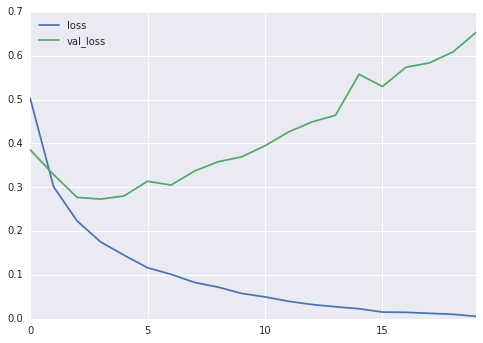

In [30]:
import seaborn
# history_dictをpandasnのデータフレームに変換
d = pd.DataFrame(history_dict)
# loss, val_lossをプロット
d[['loss', 'val_loss']].plot()
plt.show()

同様に精度についてもプロットしてみます。

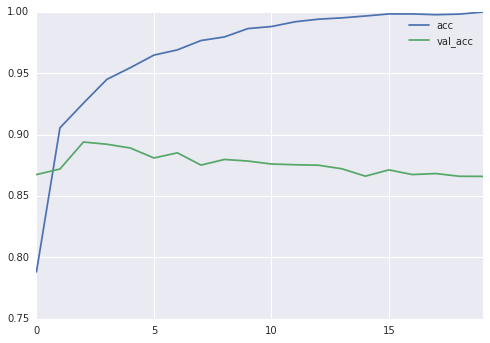

In [31]:
d[['acc', 'val_acc']].plot()
plt.show()

### 最適なモデル
グラフからエポックの値が４で十分なことが読み取れます。

テスト用のデータでモデルを性能を検証するために、nb_epoch=4で計算したモデルを準備し、evaluateメソッドを使ってテスト用データについて肯定／否定の評価を予想してみましょう。

In [32]:
model = Sequential()

In [33]:
model.add(Dense(16, activation='relu', input_dim=10000))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, nb_epoch=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 13s - loss: 0.4674 - acc: 0.8233    
Epoch 2/4
25000/25000 [==============================] - 3s - loss: 0.2706 - acc: 0.9082     
Epoch 3/4
25000/25000 [==============================] - 3s - loss: 0.2077 - acc: 0.9268     
Epoch 4/4
25000/25000 [==============================] - 77s    


In [26]:
results

[0.28935939959526064, 0.88580000000000003]

幻術的な域に達すると精度は９５％になることから、８８％の精度は、簡単な例としてはまあまあの値だと著者は評価しています。

In [27]:
model.predict(x_test)

array([[ 0.9349696 ],
       [ 0.8607676 ],
       [ 0.99898547],
       ..., 
       [ 0.61384249],
       [ 0.00223451],
       [ 0.78475696]], dtype=float32)

In [ ]:
d = pd.DataFrame(history)
d.head()